### IMPORTANDO BIBLIOTECAS/MÓDULOS

In [55]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sa
import warnings
import joblib

### CRIANDO SÉRIE TEMPORAL

In [56]:
np.random.seed(0)
data = np.random.normal(3000,1000,200)
serie = pd.DataFrame(data, columns=['Serie'])

### ANALISANDO SÉRIE TEMPORAL

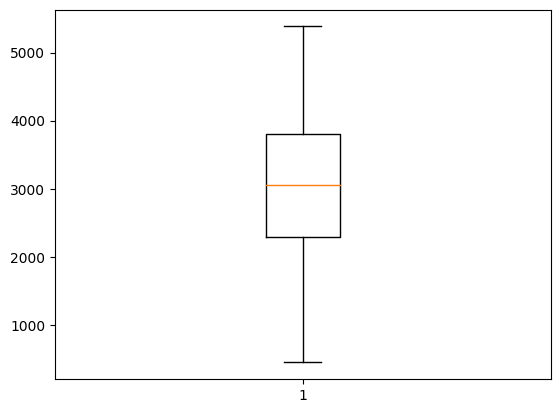

In [57]:
plt.boxplot(serie)
plt.show()

### PLOTANDO SÉRIE

<Axes: >

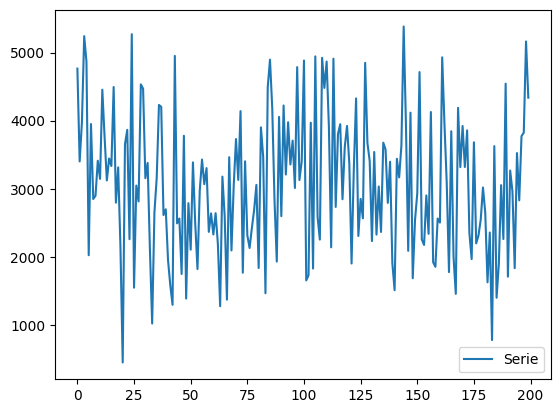

In [58]:
serie.plot()

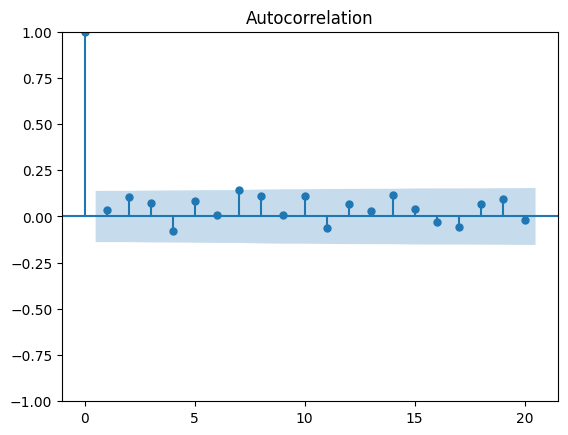

In [59]:
plot_acf(serie, lags=20)
plt.show()

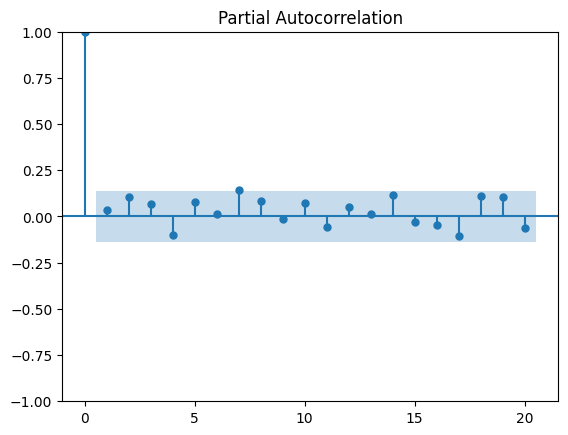

In [60]:
plot_pacf(serie, lags=20)
plt.show()

### DEFININDO BASE TREINO E TESTE

In [61]:
treino = serie['Serie'][:int(len(serie) * 0.8)]
teste = serie['Serie'][int(len(serie) * 0.8):]

print(treino.shape)
print(teste.shape)

(160,)
(40,)


### CONFIGURANDO E TREINANDO OS MODELOS ARIMA E SARIMAX

###### NO MODELO ARIMA, NÃO FOI NECESSÁRIO INCLUIR DIFERENCIAÇÃO, POIS A SÉRIE É ESTACIONÁRIA, TORNANDO O MODELO COMO 'ARMA'

In [62]:
#ARIMA

warnings.filterwarnings('ignore')

def testar(folds):
    order = (folds.suggest_int('p', 2,20),
             folds.suggest_int('d', 0,2),
             folds.suggest_int('q', 1,10)
             )
    model = ARIMA(treino, order=order).fit()
    predictions = model.forecast(steps=int(len(teste)))

    rsme = np.sqrt(mean_squared_error(teste, predictions))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(testar, n_trials=40)

best_params = study.best_params
modelo = ARIMA(treino, order=(best_params['p'],best_params['d'],best_params['q'])).fit()

[I 2024-01-31 17:38:52,573] A new study created in memory with name: no-name-81088b2f-1b45-4fd7-91f9-78ed730caa8f
[I 2024-01-31 17:38:54,719] Trial 0 finished with value: 1275.6399662691638 and parameters: {'p': 17, 'd': 2, 'q': 10}. Best is trial 0 with value: 1275.6399662691638.
[I 2024-01-31 17:38:56,848] Trial 1 finished with value: 1048.1185913843653 and parameters: {'p': 19, 'd': 1, 'q': 6}. Best is trial 1 with value: 1048.1185913843653.
[I 2024-01-31 17:38:57,547] Trial 2 finished with value: 1128.3468399424646 and parameters: {'p': 10, 'd': 2, 'q': 2}. Best is trial 1 with value: 1048.1185913843653.
[I 2024-01-31 17:38:59,997] Trial 3 finished with value: 1054.974590363899 and parameters: {'p': 20, 'd': 0, 'q': 8}. Best is trial 1 with value: 1048.1185913843653.
[I 2024-01-31 17:39:01,562] Trial 4 finished with value: 1015.8481626186566 and parameters: {'p': 15, 'd': 1, 'q': 9}. Best is trial 4 with value: 1015.8481626186566.
[I 2024-01-31 17:39:02,461] Trial 5 finished with v

In [63]:
#SARIMAX

def testar_sa(folds):
    order = (
            folds.suggest_int('p', 2,11),
            folds.suggest_int('d', 0,2),
            folds.suggest_int('q', 1,10)
             )
    seasonal_order = (
            #folds.suggest_int('P', 1,10),
            #folds.suggest_int('D', 0,2),
            #folds.suggest_int('Q', 1,10),
            #folds.suggest_int('m', 12,20)
                4,1,1,12
            )
    model = sa.tsa.SARIMAX(treino, order=order, seasonal_order=seasonal_order).fit()
    predictions = model.forecast(steps=int(len(teste)))

    rsme = np.sqrt(mean_squared_error(teste, predictions))
    return rsme

study_sa = optuna.create_study(direction='minimize')
study_sa.optimize(testar_sa, n_trials=10)

best_params = study_sa.best_params
modelo_sa = sa.tsa.SARIMAX(treino, order=(best_params['p'],best_params['d'],best_params['q']), 
                           seasonal_order=(4,1,1,12)).fit()

[I 2024-01-31 17:39:30,570] A new study created in memory with name: no-name-70783ffb-5958-4d20-b537-296014ba5f21
[I 2024-01-31 17:39:51,301] Trial 0 finished with value: 2343.266749542801 and parameters: {'p': 3, 'd': 2, 'q': 1}. Best is trial 0 with value: 2343.266749542801.
[I 2024-01-31 17:40:29,913] Trial 1 finished with value: 1083.1038624733906 and parameters: {'p': 5, 'd': 0, 'q': 8}. Best is trial 1 with value: 1083.1038624733906.


### AVALIANDO TREINAMENTO DOS MODELOS ARIMA E SARIMAX

In [ ]:
residuals = pd.DataFrame(modelo.resid)
residuals_sa = pd.DataFrame(modelo_sa.resid)

In [ ]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                  Serie   No. Observations:                  160
Model:                ARIMA(20, 0, 9)   Log Likelihood               -1318.010
Date:                Wed, 31 Jan 2024   AIC                           2698.021
Time:                        17:31:30   BIC                           2793.351
Sample:                             0   HQIC                          2736.731
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3103.6318    270.968     11.454      0.000    2572.544    3634.719
ar.L1          0.0634      0.624      0.102      0.919      -1.160       1.287
ar.L2         -0.0800      0.375     -0.213      0.8

In [ ]:
print(modelo_sa.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Serie   No. Observations:                  160
Model:             SARIMAX(5, 1, 1)x(4, 1, 1, 12)   Log Likelihood               -1235.365
Date:                            Wed, 31 Jan 2024   AIC                           2494.730
Time:                                    17:31:30   BIC                           2530.615
Sample:                                         0   HQIC                          2509.311
                                            - 160                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0610      0.098      0.624      0.532      -0.131       0.253
ar.L2          0.0758      0.108   

<Axes: ylabel='Density'>

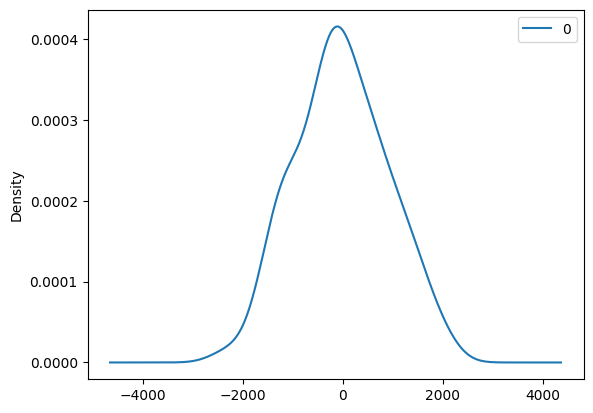

In [ ]:
residuals.plot(kind='kde')

<Axes: ylabel='Density'>

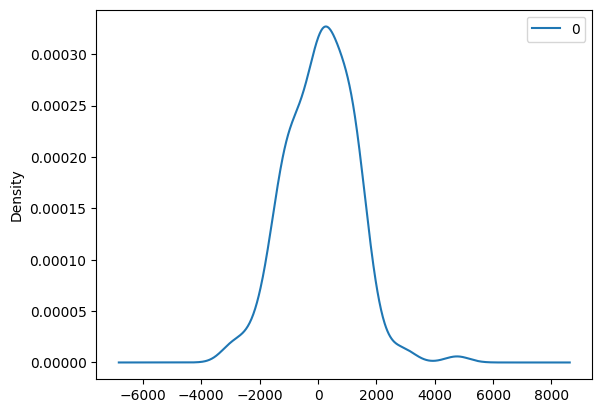

In [ ]:
residuals_sa.plot(kind='kde')

### REALIZANDO PREVISÕES E COMPARANDO COM A BASE DE TESTE

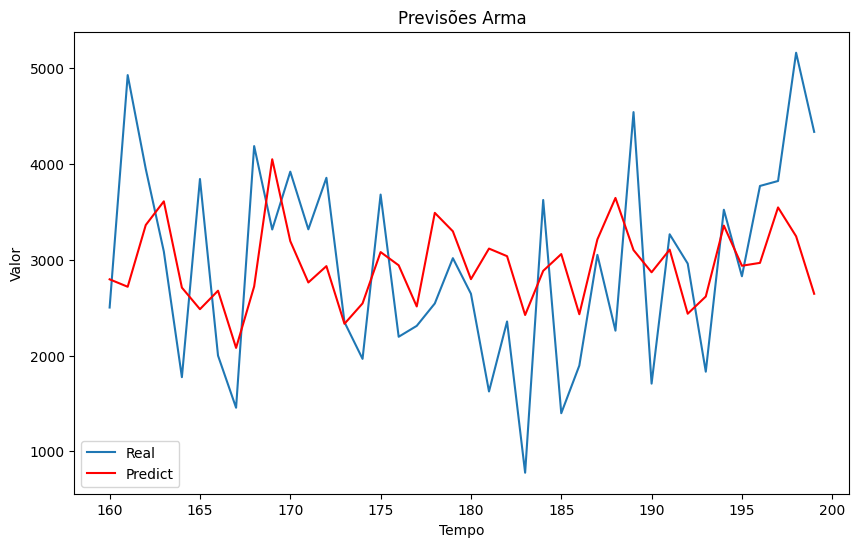

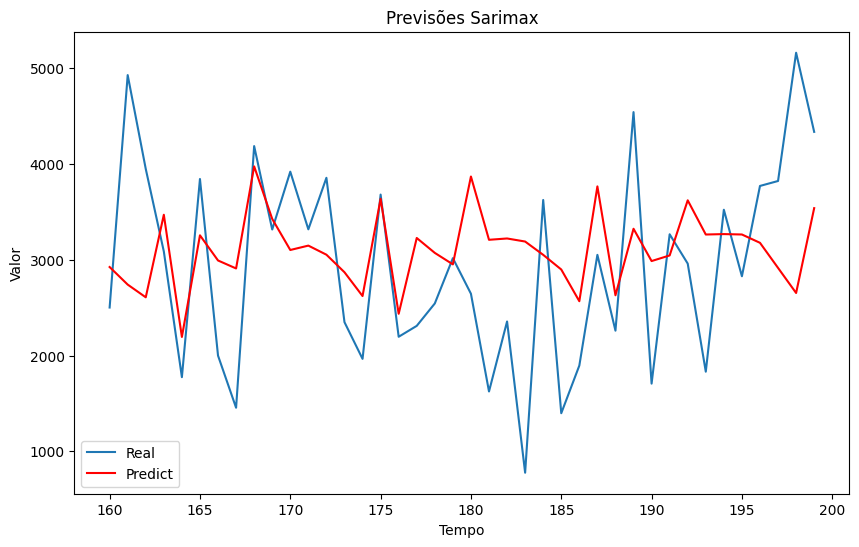

In [ ]:
n_forecast = len(teste)
forecast = modelo.forecast(steps=n_forecast)
forcast_sa = modelo_sa.forecast(steps=n_forecast)

predicts = [forecast,forcast_sa]

plt.figure(figsize=(10, 6))
plt.plot(teste)
plt.plot(forecast, color='red')
plt.title('Previsões Arma')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.figure(figsize=(10, 6))
plt.plot(teste)
plt.plot(forcast_sa, color='red')
plt.title('Previsões Sarimax')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.show()

### SALVANDO MODELOS

In [ ]:
#joblib.dump(modelo,'arima.pkl')
#joblib.dump(modelo_sa,'sarimax.pkl')

['sarimax.pkl']

### CARREGANDO MODELOS

In [ ]:
#arima = joblib.load('arima.pkl')
#sarima = joblib.load('sarimax.pkl')